# Technical Test Pythae

To run this notebook you will need a Python version >=3.8

## Preliminaries: Setup environnement & Data

In [77]:
#%pip install pythae torchvision torch torchsummary matplotlib

In [78]:
TRAIN_FLAG = True

In [79]:
import matplotlib.pyplot as plt

def plot_grid(data, grid_size=5):
    mat_data = data.data if hasattr(data, 'data') else data

    _, ax = plt.subplots(nrows=grid_size, ncols=grid_size, figsize=(8,8))

    for i in range(grid_size):
        for j in range(grid_size):
            ax[i][j].imshow(mat_data[i*grid_size+j].movedim(0, 2), cmap='gray')
            ax[i][j].axis('off')
    plt.tight_layout()

In [80]:
import torch
from torch.utils.data import Dataset
from pythae.data.datasets import DatasetOutput


class MNIST(Dataset):
    def __init__(self, data):
        self.data = data #.type(torch.float)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        return DatasetOutput(data=x)

In [81]:
import torch
from torch.utils.data import Dataset, ConcatDataset
from pythae.data.datasets import DatasetOutput
from torchvision import datasets

mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=None)

In [82]:
import random

def sample_indices(vector, k, seed=None):
    # # Example usage:
    # vector = torch.tensor([0, 0, 1, 1, 2, 2, 2, 3, 3, 3, 3])  # Example tensor with 4 labels
    # k = 3  # Number of points to sample from each label
    # seed = 42  # Seed for reproducibility
    # sampled_indices = sample_indices(vector, k, seed)
    # print("Sampled indices:", sampled_indices)

    if seed is not None:
        random.seed(seed)

    indices = []
    label_dict = {}

    # Group indices by label
    for i, label in enumerate(vector):
        label = label.item() if torch.is_tensor(label) else label
        if label not in label_dict:
            label_dict[label] = [i]
        else:
            label_dict[label].append(i)

    # Sample k points from each label
    for label, label_indices in label_dict.items():
        sampled_indices = random.sample(label_indices, min(k, len(label_indices)))
        indices.extend(sampled_indices)

    random.shuffle(indices)

    return indices

In [83]:
train_indeces = sample_indices(mnist_trainset.targets, k=200, seed=42)

remaining_indeces = list(set(range(len(mnist_trainset.targets)))-set(train_indeces))
test_indeces = sample_indices(mnist_trainset.targets[remaining_indeces], k=100, seed=42)

In [84]:
train_dataset = mnist_trainset.data[train_indeces].reshape(-1, 1, 28, 28) / 255.
eval_dataset = mnist_trainset.data[test_indeces].reshape(-1, 1, 28, 28) / 255.
print(train_dataset.shape, eval_dataset.shape)

torch.Size([2000, 1, 28, 28]) torch.Size([1000, 1, 28, 28])


In [85]:
# train_dataset = MNIST(train_dataset)
# eval_dataset = MNIST(eval_dataset)

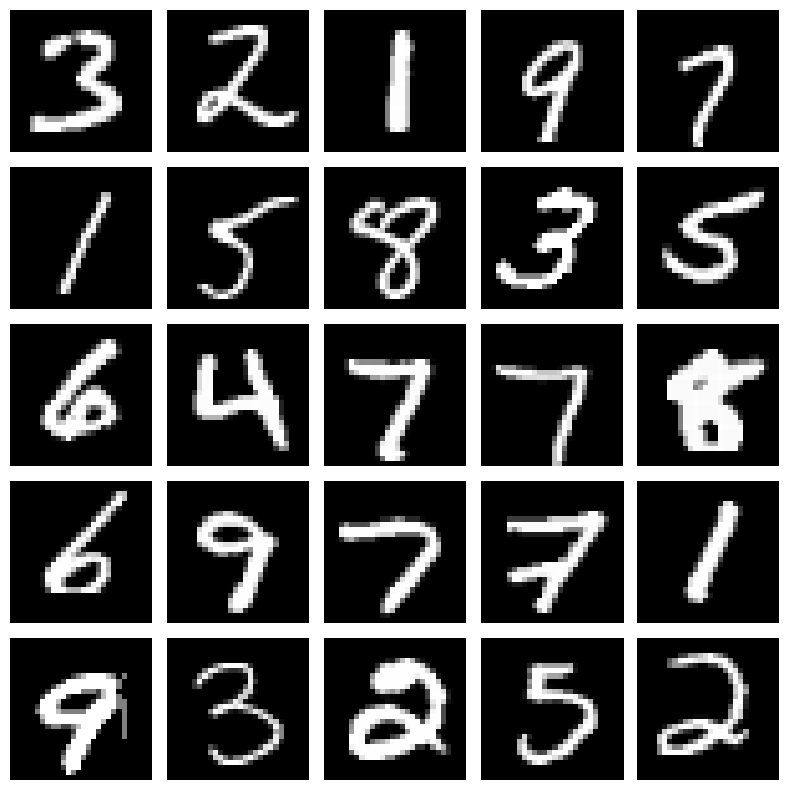

In [86]:
plot_grid(train_dataset.data)

## Step 1: Training a VAE with Pythae

In [87]:
from pythae.models import *
from pythae.models.nn.benchmarks.mnist import *

# model_config = RHVAEConfig(
#     input_dim=(1, 28, 28),
#     latent_dim=8
# )

# model = RHVAE(
#     model_config=model_config,
#     encoder=Encoder_ResNet_VAE_MNIST(model_config),
#     decoder=Decoder_ResNet_AE_MNIST(model_config)
# )

model_config = VAEConfig(
    input_dim=(1, 28, 28),
    latent_dim=8
)

model = VAE(
    model_config=model_config,
    encoder=Encoder_ResNet_VAE_MNIST(model_config),
    decoder=Decoder_ResNet_AE_MNIST(model_config)
)

In [88]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

%time count_parameters(model)

CPU times: user 574 µs, sys: 34 µs, total: 608 µs
Wall time: 618 µs


717521

In [89]:
print(model)

VAE(
  (decoder): Decoder_ResNet_AE_MNIST(
    (layers): ModuleList(
      (0): Linear(in_features=8, out_features=2048, bias=True)
      (1): ConvTranspose2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (2): Sequential(
        (0): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (1): ResBlock(
          (conv_block): Sequential(
            (0): ReLU()
            (1): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): ReLU()
            (3): Conv2d(32, 128, kernel_size=(1, 1), stride=(1, 1))
          )
        )
        (2): ReLU()
      )
      (3): Sequential(
        (0): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
        (1): ReLU()
      )
    

In [90]:
from pythae.trainers import BaseTrainerConfig, BaseTrainer
from pythae.pipelines.training import TrainingPipeline

training_config = BaseTrainerConfig(
    output_dir='experiments',
    num_epochs=100,
    learning_rate=1e-3,
    per_device_train_batch_size=1000,
    per_device_eval_batch_size=1000,
    optimizer_params={'weight_decay':1e-4}
)

# trainer = BaseTrainer(
#     model=model,
#     train_dataset=train_dataset,
#     eval_dataset=eval_dataset,
#     training_config=training_config
# )

# trainer.train()

pipeline = TrainingPipeline(
        training_config=training_config,
        model=model
)


if TRAIN_FLAG:
    pipeline(
        train_data=train_dataset,
        eval_data=eval_dataset
    )
else:
    pass

Preprocessing train data...
Checking train dataset...
Preprocessing eval data...

Checking eval dataset...
Using Base Trainer

Model passed sanity check !
Ready for training.

Created experiments/VAE_training_2024-04-10_15-28-50. 
Training config, checkpoints and final model will be saved here.

Training params:
 - max_epochs: 100
 - per_device_train_batch_size: 1000
 - per_device_eval_batch_size: 1000
 - checkpoint saving every: None
Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0.0001
)
Scheduler: None

Successfully launched training !



Training of epoch 1/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 1/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 77.6715
Eval loss: 67.962
--------------------------------------------------------------------------


Training of epoch 2/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 2/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 65.1059
Eval loss: 57.1041
--------------------------------------------------------------------------


Training of epoch 3/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 3/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 54.5924
Eval loss: 48.0049
--------------------------------------------------------------------------


Training of epoch 4/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 4/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 46.4844
Eval loss: 43.1449
--------------------------------------------------------------------------


Training of epoch 5/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 5/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 42.5589
Eval loss: 41.2158
--------------------------------------------------------------------------


Training of epoch 6/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 6/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 40.703
Eval loss: 39.2363
--------------------------------------------------------------------------


Training of epoch 7/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 7/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 38.2297
Eval loss: 35.8982
--------------------------------------------------------------------------


Training of epoch 8/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 8/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 35.0303
Eval loss: 33.1974
--------------------------------------------------------------------------


Training of epoch 9/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 9/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 32.5681
Eval loss: 31.4688
--------------------------------------------------------------------------


Training of epoch 10/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 10/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 31.1267
Eval loss: 30.9032
--------------------------------------------------------------------------


Training of epoch 11/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 11/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 30.5652
Eval loss: 30.2382
--------------------------------------------------------------------------


Training of epoch 12/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 12/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 30.0201
Eval loss: 29.5816
--------------------------------------------------------------------------


Training of epoch 13/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 13/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 29.3824
Eval loss: 29.1725
--------------------------------------------------------------------------


Training of epoch 14/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 14/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.8996
Eval loss: 28.7682
--------------------------------------------------------------------------


Training of epoch 15/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 15/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.4834
Eval loss: 28.3498
--------------------------------------------------------------------------


Training of epoch 16/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 16/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.1673
Eval loss: 28.2179
--------------------------------------------------------------------------


Training of epoch 17/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 17/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 28.0153
Eval loss: 27.9901
--------------------------------------------------------------------------


Training of epoch 18/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 18/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.7532
Eval loss: 27.7735
--------------------------------------------------------------------------


Training of epoch 19/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 19/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.488
Eval loss: 27.3827
--------------------------------------------------------------------------


Training of epoch 20/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 20/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.2361
Eval loss: 27.3238
--------------------------------------------------------------------------


Training of epoch 21/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 21/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 27.1465
Eval loss: 27.1355
--------------------------------------------------------------------------


Training of epoch 22/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 22/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.933
Eval loss: 26.9746
--------------------------------------------------------------------------


Training of epoch 23/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 23/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.776
Eval loss: 26.7682
--------------------------------------------------------------------------


Training of epoch 24/100:   0%|          | 0/2 [00:00<?, ?batch/s]

Eval of epoch 24/100:   0%|          | 0/1 [00:00<?, ?batch/s]

--------------------------------------------------------------------------
Train loss: 26.674
Eval loss: 26.6003
--------------------------------------------------------------------------


Training of epoch 25/100:   0%|          | 0/2 [00:00<?, ?batch/s]

## Step 2: Generating synthetic images with PythAE

In [ ]:
from pythae.models import AutoModel

import glob

if TRAIN_FLAG:
    trained_model = model
else:
    trained_model = AutoModel.load_from_folder(
        glob.glob('experiments/*/final_model')[0]
    )

### Normal Sampler

In [ ]:
from pythae.samplers import NormalSampler


sampler = NormalSampler(
    model=trained_model,
    sampler_config=None
)
gen_data = sampler.sample(
    num_samples=25,
)

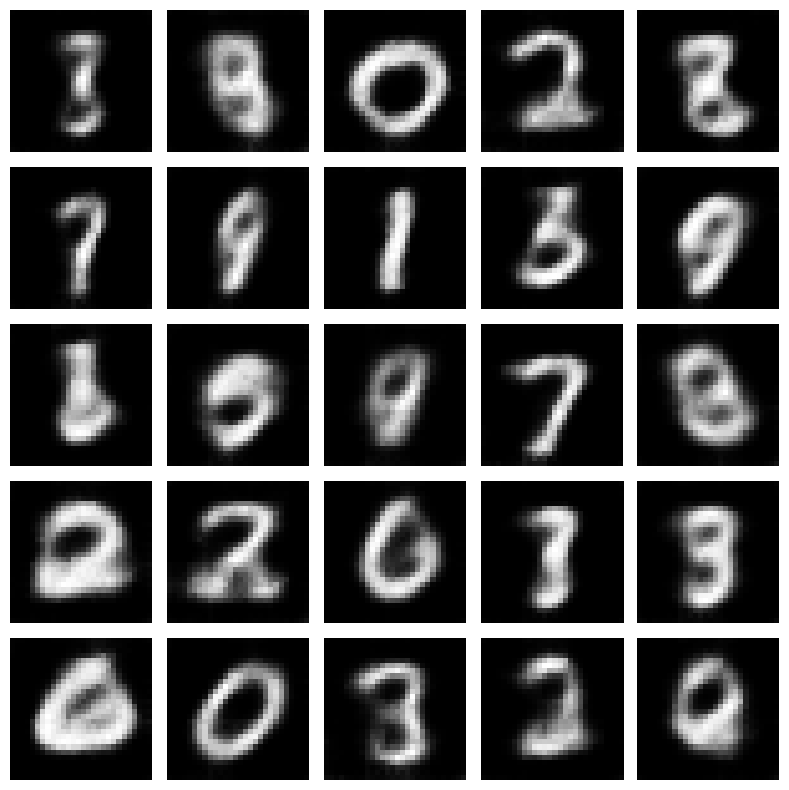

In [ ]:
plot_grid(gen_data.data)

### Gaussian Mixture Model Sampler

In [ ]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig


gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

gmm_sampler.fit(
    train_data=train_dataset
)

gmm_gen_data = gmm_sampler.sample(
   num_samples=25
)

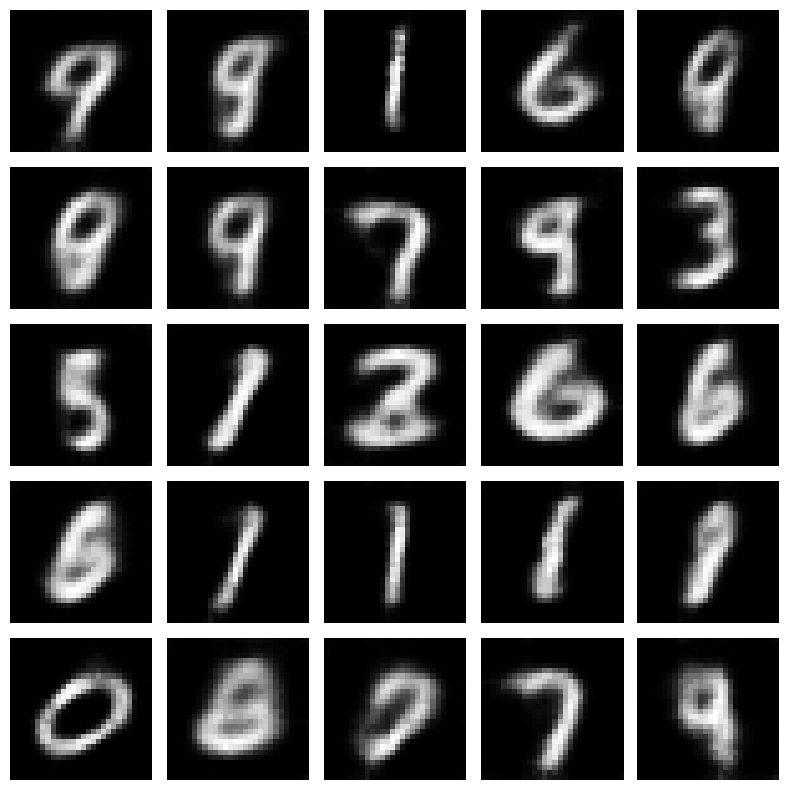

In [ ]:
plot_grid(gmm_gen_data.data)

### RHVAE Sampler

In [ ]:
from pythae.samplers import RHVAESampler, RHVAESamplerConfig


rh_sampler_config = RHVAESamplerConfig(
)

rh_sampler = RHVAESampler(
    sampler_config=None,
    model=trained_model
)

rh_sampler.fit(
    train_data=train_dataset
)

rh_gen_data = rh_sampler.sample(
   num_samples=25
)

AttributeError: 'VAE' object has no attribute 'M_tens'

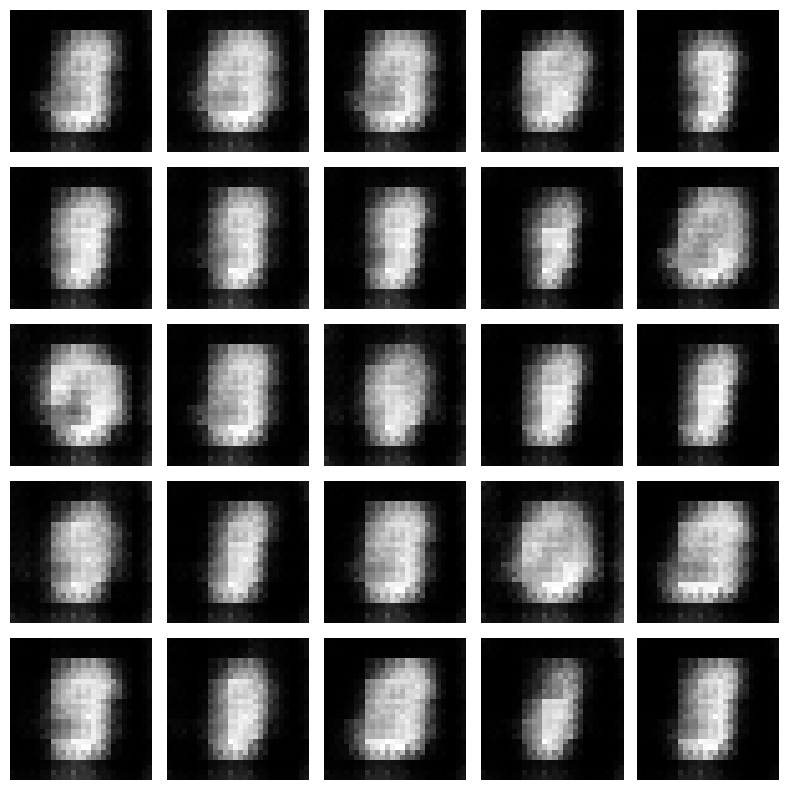

In [ ]:
plot_grid(rh_gen_data)

In [ ]:
rh_gen_data.shape

torch.Size([25, 1, 28, 28])

In [ ]:
#combined_dataset = ConcatDataset([train_dataset, rh_gen_data])
combined_dataset = torch.cat((train_dataset, rh_gen_data), 0)
combined_dataset = combined_dataset[torch.randperm(combined_dataset.size()[0])]
combined_dataset.shape

torch.Size([2025, 1, 28, 28])